In [1]:
import os
from sys import stdout
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils

import matplotlib
#%matplotlib notebook
#%matplotlib inline
#matplotlib.use('nbagg')
#import mpld3
#mpld3.enable_notebook()

from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

import numpy as np
from numpy.linalg import norm
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter
import scipy.io

import warnings
warnings.filterwarnings('ignore')

In [2]:
def drPLS(x_input,y_input, **kwargs):
    """
    drPLS: (automatic) Baseline correction method based on doubly reweighted penalized least squares.
    Xu et al., Applied Optics 58(14):3913-3920.
    
    Allows subtracting a baseline under a x y spectrum.
    
    Parameters
    ----------
    x_input : ndarray
        x values.
    
    y_input : ndarray
        y values.
        
    kwargs:  #optional parameters
        niter = kwargs.get('niter',100)
        lam = kwargs.get('lam',1000000)
        eta = kwargs.get('eta',0.5)
        ratio = kwargs.get('ratio',0.001)

    Returns
    -------
    out1 : ndarray
        Contain the corrected signal.
    out2 : ndarray
        Contain the baseline.
    """
    # we get the signals in the bir
    # yafit_unscaled = get_portion_interest(x_input,y_input,bir)

    # signal standard standardization with sklearn
    # this helps for polynomial fitting
    X_scaler = StandardScaler().fit(x_input.reshape(-1, 1))
    Y_scaler = StandardScaler().fit(y_input.reshape(-1, 1))

    # transformation
    x = X_scaler.transform(x_input.reshape(-1, 1))
    y = Y_scaler.transform(y_input.reshape(-1, 1))

    #yafit = np.copy(yafit_unscaled)
    #yafit[:,0] = X_scaler.transform(yafit_unscaled[:,0].reshape(-1, 1))[:,0]
    #yafit[:,1] = Y_scaler.transform(yafit_unscaled[:,1].reshape(-1, 1))[:,0]

    y = y.reshape(len(y_input))    
    
    #according to Applied Optics, 2019, 58, 3913-3920.

    #optional parameters
    niter = kwargs.get('niter',100)
    lam = kwargs.get('lam',1000000)
    eta = kwargs.get('eta',0.5)
    ratio = kwargs.get('ratio',0.001)

    #optional smoothing in the next line, currently commented out
    #y = np.around(savgol_filter(raw_data,19,2,deriv=0,axis=1),decimals=6)

    L = len(y)

    D = sparse.diags([1,-2,1],[0,-1,-2],shape=(L,L-2),format='csr')
    D = D.dot(D.transpose())
    D_1 = sparse.diags([-1,1],[0,-1],shape=(L,L-1),format='csr')
    D_1 = D_1.dot(D_1.transpose())

    w_0 = np.ones(L)
    I_n = sparse.diags(w_0,format='csr')

    #this is the code for the fitting procedure
    w = w_0
    W = sparse.diags(w,format='csr')
    Z = w_0

    for jj in range(int(niter)):
        W.setdiag(w)
        Z_prev = Z
        Z = sparse.linalg.spsolve(W + D_1 + lam * (I_n - eta*W) * D,W*y,permc_spec='NATURAL')
        if np.linalg.norm(Z - Z_prev) > ratio:
            d = y - Z
            d_negative = d[d<0]
            sigma_negative = np.std(d_negative)
            mean_negative = np.mean(d_negative)
            w = 0.5 * (1 - np.exp(jj) * (d - (-mean_negative + 2*sigma_negative))/sigma_negative / (1 + np.abs(np.exp(jj) * (d - (-mean_negative + 2*sigma_negative))/sigma_negative)))
        else:
            break
    #end of fitting procedure

    baseline_fitted = Z

    return y_input.reshape(-1,1)-Y_scaler.inverse_transform(baseline_fitted.reshape(-1, 1)), Y_scaler.inverse_transform(baseline_fitted.reshape(-1, 1))

In [3]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [5]:
mat = scipy.io.loadmat("./data/H01.mat")
data = mat["data"]
wl = mat["wl"]
refconc= mat["refconc"]
refconc = refconc[0][0][2]

In [6]:
print(wl[-1])
print(wl.shape)
print(data.shape)

[340.37]
(3648, 1)
(3648, 2024)


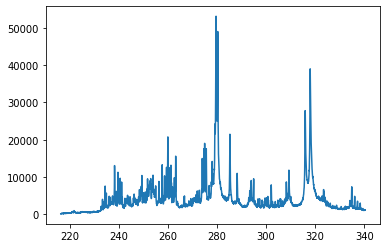

In [7]:
plt.plot(wl, data[:,10])

In [13]:
#for i in range(len(data[0])):
#    print(max(data[:,i]))

116
143
38565
30886
48088
48294
26991
13523
57574
49524
53121
24957
33648
33994
15628
51656
20912
14727
58105
25867
17793
45889
51039
46918
37088
20129
43894
15780
53506
40838
28478
29250
49273
28994
29576
42698
39834
3705
48974
49508
33416
44417
65380
12769
40919
36907
37586
39101
18685
28287
54104
55759
15681
57510
45811
46447
22720
30718
31562
53232
35463
37892
36520
35524
34122
56255
41826
28449
13450
62104
5705
33767
24424
36134
35165
17765
23953
57593
16991
13339
63517
51900
45698
41553
19635
51784
42120
31526
7015
42677
52311
29071
44431
48281
32912
44405
39019
13639
44287
52275
23069
20950
20822
17907
54030
26403
16589
64767
33669
52453
33768
17744
51590
46417
52573
12333
4683
49678
41735
39270
34540
19786
26531
56055
28177
45004
60250
38050
40369
48539
3105
55642
23950
26102
56982
54379
57965
46326
43175
40783
43827
52950
57939
34273
14160
23633
29703
22829
25234
22224
31051
28746
49647
47827
42377
35057
55391
290
46380
54035
24808
11628
53608
35428
11314
19814
44933
18808
492

55866
41201
28173
47834
44800
30122
65336
40204
25403
37889
57323
65327
19132
37305
33942
51370
24913
61776
65340
28635
48164
32807
47216
35788
25649
40469
57014
26191
21315
50279
47988
47372
41367
65371
59362
26485
45976
62710
32531
40969
30079
41010
55132
21382
43365
58140
52413
45872
36665
57446
65348
35480
24816
65364
57571
25386
58118
23664
65377
43175
35401
44358
55292
46091
63756
57394
48776
35694
32290
24629
31303
44529
64602
48983
45938
59203
65387
50900
22855
49722
63742
60672
12121
49686
20549
17959
59501
24129
63693
57353
16176
13621
38132
55225
56315
65347
61294
54309
23543
65355
42319
45957
54484
58249
65348
49801
65045
55109
27689
47475
65357
44673
34781
48474
42425
15392
36878
25732
40178
24879
35018
63403
51064
25040
61476
25163
65370
51457
36149
32535
60479
22372
51948
39189
38406
22845
55105
65187
33670
29662
46465
57062
32614
30532
45225
38660
23443
33951
65351
65338
21945
62637
24524
58725
27573
30689
27918
65356
55860
44906
61901
37169
32486
46438
65363
32883
2342

In [12]:
print(len(data[0]))

2024


In [8]:
from glob import glob

#filenames = glob('./ref/*')
filenames = glob('./data/*')


dfs = [scipy.io.loadmat(f) for f in filenames]
print(type(dfs)) #dfs is a list of mat files 
print(len(dfs)) #dfs is a list of mat files 

<class 'list'>
34


In [9]:
print(data[:,-1].shape)
print(data[-1].shape)
print(len(data))
print(len(data[0]))
print(data.shape)
print(wl.shape)

(3648,)
(2024,)
3648
2024
(3648, 2024)
(3648, 1)


<IPython.core.display.Javascript object>


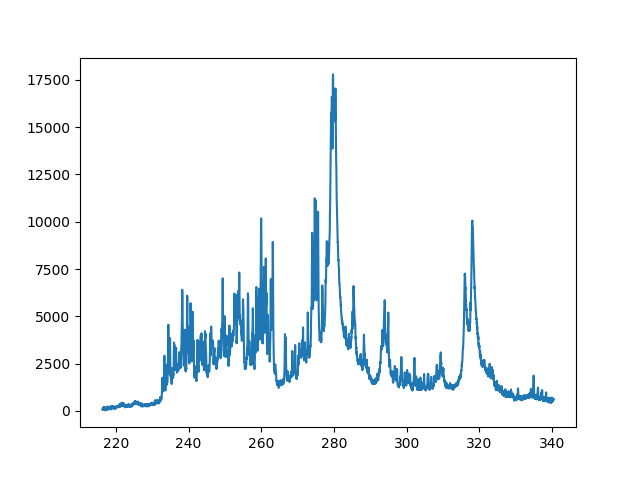

In [11]:
%matplotlib notebook
plt.plot(wl, data[:,20])
plt.show()

(3648, 1)
[134.55869665]


<IPython.core.display.Javascript object>


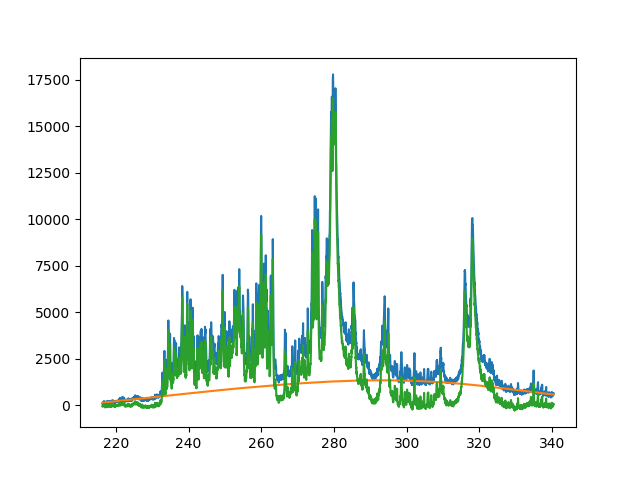

In [13]:
orig= data[:,20]

corrected, x1= drPLS(wl, orig, lam= 10e9) #lambda

print(x1.shape)
print(x1[0])

%matplotlib notebook
plt.plot(wl, orig)
plt.plot(wl, x1)
plt.plot(wl, corrected)
plt.show()

(3648, 1)
(3648, 1)


<IPython.core.display.Javascript object>


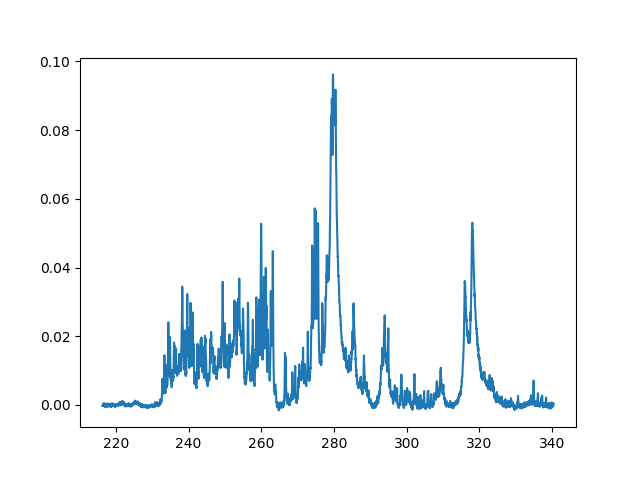

In [13]:
#a, b = msc((pd.DataFrame(corrected).dropna()).values)
a =  corrected / np.sum(corrected,axis=0)
b =  corrected / np.max(corrected,axis=0)
c= normalize (corrected.reshape(1, -1))

print(a.shape)
print(wl.shape)

%matplotlib notebook
#plt.plot(wl, corrected)
#plt.plot(wl, a)
#plt.plot(wl, b)
plt.plot(wl, c.T)
plt.show()

In [15]:
## THIS IS THE COMPLETE LOOP FOR DATA MANIPULATION

#print("the wavelength used for intensity filtering is: ", wl[445])

tot= np.empty((0, len(wl)))
print( "tot shape: " , tot.shape)

for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))
    
    for i in (range(len(data[0])) ):
        
        orig= data[:,i]
        
        #if ((max(orig)) < 65500):
        #if ((max(orig)) < 65500) and ((max(orig)) > 25500):
            
        corrected, x1= drPLS(wl, orig, lam= 10e7)
        #print(corrected.shape)

        #if  max(corrected) > 10000:
        if max(corrected) > 10000 and (max(orig)) < 60000:
            count += 1

            #corrected = normalize (corrected.reshape(1, -1))
            #corrected= snv(corrected.reshape(1, -1))
            #corrected =  corrected / np.sum(corrected,axis=0)
            #corrected =  corrected / np.max(corrected,axis=0)
            
            tmp = np.append(tmp, corrected.reshape(1, -1), axis=0)

            #print("a:", a.shape)
            #print("tmp:", tmp.shape)

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape, "\n")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

tot shape:  (0, 3648)
data index: 0
data 0 shape:  (3648, 2024)
good spectra:  1708
tmp shape:  (1708, 3648)
avg array shape:  (1, 3648) 

data index: 1
data 1 shape:  (3648, 2058)
good spectra:  1818
tmp shape:  (1818, 3648)
avg array shape:  (1, 3648) 

data index: 2
data 2 shape:  (3648, 1583)
good spectra:  1386
tmp shape:  (1386, 3648)
avg array shape:  (1, 3648) 

data index: 3
data 3 shape:  (3648, 2027)
good spectra:  1418
tmp shape:  (1418, 3648)
avg array shape:  (1, 3648) 

data index: 4
data 4 shape:  (3648, 2038)
good spectra:  1597
tmp shape:  (1597, 3648)
avg array shape:  (1, 3648) 

data index: 5
data 5 shape:  (3648, 2009)
good spectra:  1862
tmp shape:  (1862, 3648)
avg array shape:  (1, 3648) 

data index: 6
data 6 shape:  (3648, 2268)
good spectra:  1753
tmp shape:  (1753, 3648)
avg array shape:  (1, 3648) 

data index: 7
data 7 shape:  (3648, 2034)
good spectra:  1699
tmp shape:  (1699, 3648)
avg array shape:  (1, 3648) 

data index: 8
data 8 shape:  (3648, 2169)


<IPython.core.display.Javascript object>


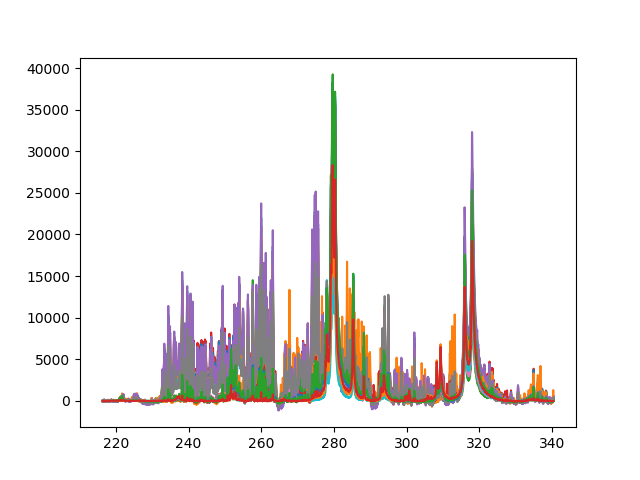

In [18]:
%matplotlib notebook
#%matplotlib inline

for i in range(len(tot)):
    #print(i)
    plt.plot(wl, tot[i])
    plt.show()

In [19]:
print(wl.shape)
wl1= wl.reshape(1,-1)
print(tot.shape)

a= np.append(wl1, tot, axis=0)
print(a.shape)
print(a)

np.savetxt("avg_base_wl_basic_25-02.csv", a, delimiter=",", fmt='%f')

(3648, 1)
(34, 3648)
(35, 3648)
[[216.33       216.37       216.41       ... 340.32       340.34
  340.37      ]
 [-34.08050575 -52.85623825 -53.53126753 ... -42.33219404 -19.90168897
    3.39239935]
 [-35.61891854 -60.4995093  -60.72498389 ...  12.65563052  38.60206324
   69.21901209]
 ...
 [-20.31166625 -30.87041883 -32.01073496 ... -14.46972175 -11.08744897
  -18.93096558]
 [-27.95113919 -40.76510232 -42.00769775 ...  -6.89922421 -11.13762028
  -23.9104097 ]
 [-14.02844981 -26.8753733  -26.67320091 ... -10.94503675  -8.65772873
  -13.4634437 ]]


### Wavelet transform

In [18]:
import pywt
import pywt.data
#print(pywt.families(short=False))
print(pywt.families(short=True), "\n")
print(pywt.wavelist(kind='discrete'))

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'] 

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sy

<IPython.core.display.Javascript object>


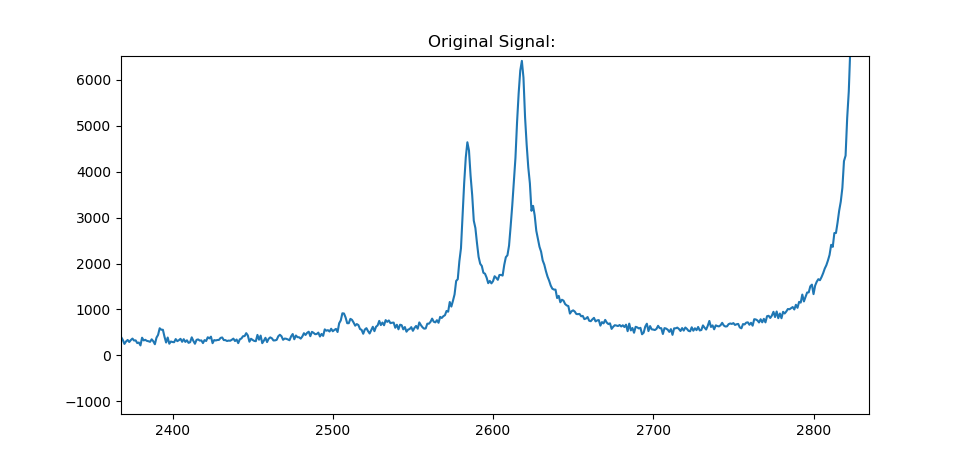

(3648,)


<IPython.core.display.Javascript object>


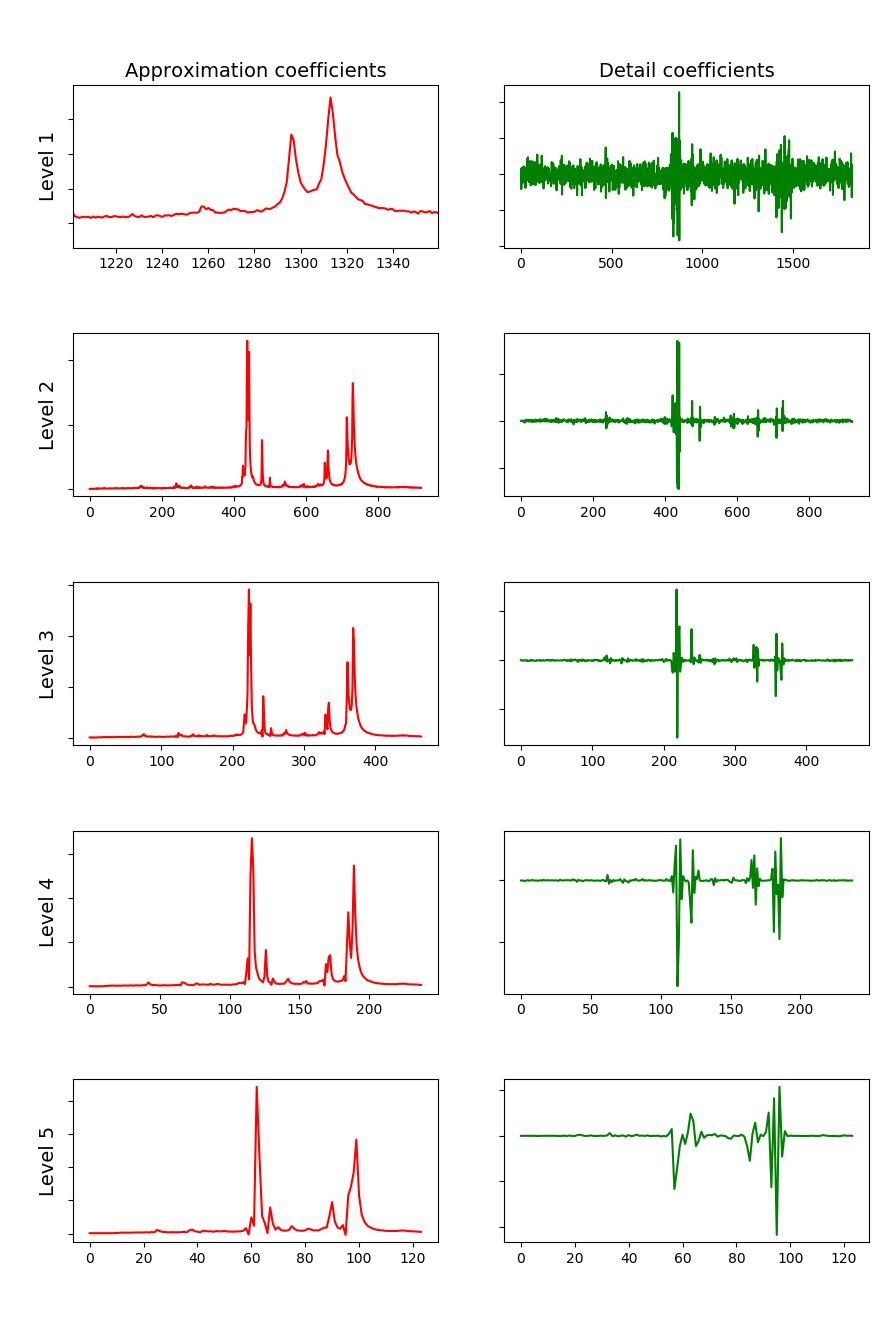

In [42]:
%matplotlib notebook


fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Signal: ")
ax.plot(data[:,10])
plt.show()
    
data1 = data[:,10]
print(data1.shape)
waveletname = 'db6'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data1, coeff_d) = pywt.dwt(data1, waveletname)
    axarr[ii, 0].plot(data1, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [67]:
a, b =pywt.swt(data1, waveletname, level=2) 

print(type(a))
print(len(a))
print(a[1].shape)
print(type(a[0]))
print(b[1].shape)
print(type(b[0]))

print(type(a))
print(len(a))
print(type(a[1]))
print(type(a[0]))
print(a[0][0].shape)
print(a[0][0])

#plt.plot(wl, a[0][0])

<class 'tuple'>
2
(124,)
<class 'numpy.ndarray'>
(124,)
<class 'numpy.ndarray'>
<class 'tuple'>
2
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
()
3371.4281153625648


- The DWT return two sets of coefficients; the approximation coefficients and detail coefficients.
- The approximation coefficients represent the output of the low pass filter (averaging filter) of the DWT.
- The detail coefficients represent the output of the high pass filter (difference filter) of the DWT.
- By applying the DWT again on the approximation coefficients of the previous DWT, we get the wavelet transform of the next level.
- At each next level, the original signal is also sampled down by a factor of 2.

<IPython.core.display.Javascript object>


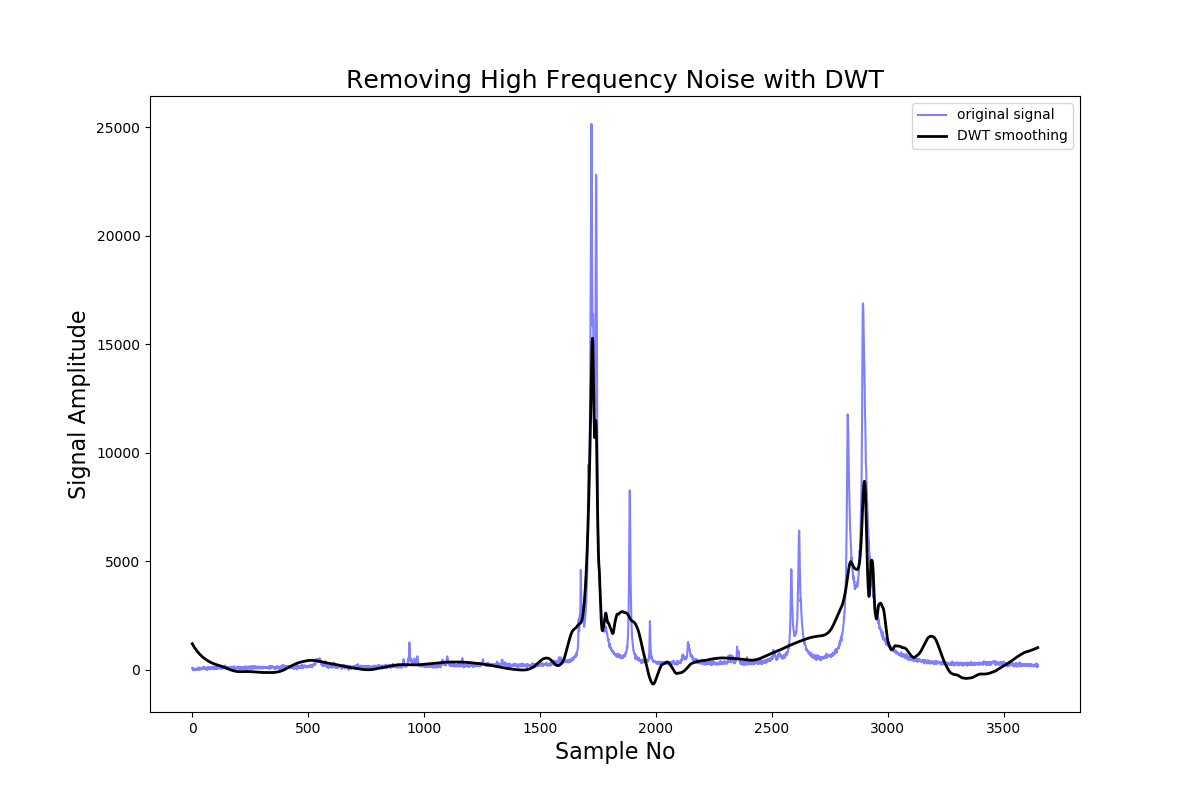

In [30]:
#Is this even useful???

signal = data[:,10]

def lowpassfilter(signal, thresh = 0.63, wavelet="db6"):
#def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="sp1" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="sp1" )
    return reconstructed_signal
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.4)
ax.plot(rec, 'k', label='DWT smoothing', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

# Normalization

In [16]:
data[0,:]

array([4834., 4823., 4700., ..., 4533., 4572., 4599.])

In [17]:
a= normalize(data[0,:].reshape(1, -1))
a.shape

(1, 1446)

In [18]:
print(wl.shape)
print(a.shape)

(1446,)
(1, 1446)


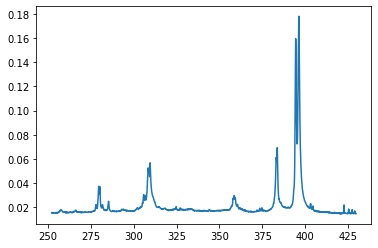

In [21]:
%matplotlib inline
plt.plot(wl, a.T)
plt.show()

(1446,)
(100, 1446)


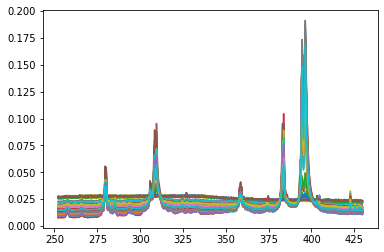

In [23]:
tmp=normalize(data)
print(wl.shape)
print(tmp.shape)


%matplotlib inline
for i in range(len(tmp)):
    plt.plot(wl, tmp[i,:])
    #plt.show()

In [24]:
print(wl.shape)
print(len(wl))

(1446,)
1446


In [ ]:
tot= np.empty((0, len(wl)))


for j in range(0, len(dfs)):
    data = dfs[j].values
    data = data[1:,:]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))

    
    for i in (range(len(data)) ):
    
        z_i = baseline_als(data[i,:], lam, p, niter=10)

        a = data[i,:] - z_i


        if (max(a)) > 25000:

            #a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            #plt.plot(wl, a)
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape) 

In [ ]:
for i in range(len(tot)):
    plt.plot(wl, tot[i])
    #plt.show()

In [ ]:
print(tot.shape)
print(wl.shape)

In [ ]:
print(wl.shape)
wl= wl.reshape(1,-1)
print(tot.shape)

a= np.append(wl, tot, axis=0)
print(a.shape)
print(a)

In [ ]:
#np.savetxt("avg_intesities_baseline_1.csv", a, delimiter=",", fmt='%f')

In [ ]:
X_std = StandardScaler().fit_transform(data)
print(X_std.shape)
X_std

In [ ]:
data_sum= data / np.sum(data,axis=0)
data_sum

In [ ]:
for i in (range(len(X_std[0]))):
    
    plt.plot(wl, X_std[:,i] )
    plt.show()
    

In [ ]:
print(max(data[:,8]))
print(max(data[:,11]))
max(data[:,1])

In [ ]:
count = 0
for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[:,i], lam, p, niter=10)
    
    a = data[:,i] - z_i
    
    #a=  a / np.sum(a,axis=0)
    #a=  a / np.max(a,axis=0)


    count += 1
    #print(i)
    plt.plot(wl, a)
    #plt.show()
print("good spectra: ", count)

In [ ]:
count = 0
for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[600:1730,i], lam, p, niter=10)
    
    a = data[600:1730,i] - z_i
    
    
    if (max(a)) > 25000:
        
        a =  a / np.sum(a,axis=0)
        #a = StandardScaler().fit_transform(a.reshape(-1, 1))
        #a= normalize(a.reshape(-1, 1))
        
        count += 1
        #print(i)
        plt.plot(wl[600:1730], a)
        plt.show()
        #plt.savefig('./graph.png')
print("good spectra: ", count)

In [ ]:
count=0

#result_array = np.empty_like(wl)
tmp = np.empty((0, len(wl)))

for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[:,i], lam, p, niter=10)
    
    if ((max(data[:,i]-z_i)) > 10000) and ((max(data[:,i])) < 65500):
        count += 1
        #print(i)
        plt.plot(wl, data[:,i])
        #plt.show()
        tmp = np.append(tmp, [data[:,i]], axis=0)
        
        
print("good spectra: ", count)
print(tmp.shape)

avg_arr= np.max(tmp, axis=0)
#avg_arr= np.mean(tmp, axis=0)
print(avg_arr.shape)




In [ ]:
count=0

#result_array = np.empty_like(wl)
tmp = np.empty((0, len(wl)))

for i in (range(len(data[0])) ):
    if ((max(data[:,i])) > 10000) and ((max(data[:,i])) < 65500):
        count += 1
        #print(i)
        plt.plot(wl, data[:,i])
        #plt.show()
        result_array = np.append(tmp, [data[:,i]], axis=0)
        
        
print("good spectra: ", count)
print(tmp.shape)

avg_arr= np.mean(tmp, axis=0)
print(avg_arr.shape)



In [ ]:

plt.plot(wl, avg_arr)
plt.show()

In [ ]:

good = np.empty([len(wl)])

good1 = np.empty_like(wl)

print(good.shape)
print(good1.shape)

In [ ]:
print(result_array.shape)
print(result_array)
a=np.mean(result_array, axis=0)
print(a.shape)

In [ ]:
"""from glob import glob

#filenames = glob('./ref/*')
filenames = glob('./ref_1/*')


dfs = [scipy.io.loadmat(f) for f in filenames]
print(type(dfs)) #dfs is a list of mat files 
print(len(dfs)) #dfs is a list of mat files 
"""

In [ ]:
tot= np.empty((0, len(wl)))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))

    for i in (range(len(data[0])) ):
        
        
    
        if ((max(data[:,i])) > 10000) and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [data[:,i]], axis=0)


    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    #avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

WITH BASELINE CORRECTION

In [ ]:
tot= np.empty((0, len(wl[600:1730])))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl[600:1730])))

    
    for i in (range(len(data[0])) ):
    
        z_i = baseline_als(data[600:1730,i], lam, p, niter=10)

        a = data[600:1730,i] - z_i


        if (max(a)) > 25000:

            a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            plt.plot(wl[600:1730], a)
            plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

In [ ]:
tot= np.empty((0, len(wl[600:1730])))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl[600:1730])))

    
    for i in (range(len(data[0])) ):
        if (max(data[:,i])) > 25000:
            
            
            z_i = baseline_als(data[600:1730,i], lam, p, niter=10)

            a = data[600:1730,i] - z_i


        

            a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            #plt.plot(wl[600:1730], a)
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

In [ ]:
for i in range(len(tot)):
    plt.plot(wl[600:1730], tot[i])
    #plt.show()

In [ ]:
ded #np.savetxt("avg_intesities.csv", tot, delimiter=",", fmt='%f')

In [ ]:
print(wl.shape)
wl1= wl[600:1730].reshape(1,-1)
print(tot.shape)

a= np.append(wl1, tot, axis=0)
a.shape
a

In [ ]:
#np.savetxt("avg_intesities_baseline_1.csv", a, delimiter=",", fmt='%f')